The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


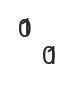

In [76]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.models import Standardizer, NNAlign
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.bootstrap import get_pval, plot_pval
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
mpl.rcParams['figure.dpi'] = 180

In [3]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
viral = pd.read_csv('../data/other/viral.csv').rename(columns={'sequence':'Peptide'})
drb = pd.read_csv('../data/NetMHCIIpan_train/drb1_0301.csv')

# check dataset / extra features behaviour

In [11]:
from src.datasets import get_NNAlign_dataloader, NNAlignDataset
loader, dataset = get_NNAlign_dataloader(cedar_aligned, max_len=12, window_size=6, encoding='BL50LO', 
                                        seq_col='Peptide', target_col='agg_label', pad_scale=-15, return_dataset=True, 
                                        feature_cols = ['EL_rank_mut', 'icore_dissimilarity_score'])

In [21]:
from src.models import NNAlign
# Taking a sample and testing some stuff
xd, xd_mask, _, _ = dataset[50:100]
x_tensor, x_mask, x_features, y_true = dataset[:10]
mymodel = NNAlign(30, 6)
mymodel.fit_standardizer(xd, xd_mask)
z = mymodel(x_tensor, x_mask)

In [23]:
x_features.shape, z.shape

(torch.Size([10, 2]), torch.Size([10, 1]))

In [29]:
torch.cat([z, x_features], dim=1).shape

torch.Size([10, 3])

# Rearrange data

In [52]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230418_nepdb_aligned.csv')

In [53]:
rename_cols = {'Peptide':'mutant', 'agg_label':'target', 'icore_dissimilarity_score':'icore_selfsimilarity'}
cols_ = list(filter(lambda x: 'mixed' not in x and 'improves' not in x.lower() and 'Unnamed' not in x and 'fullpep_vs_icore_rank' not in x, cedar_aligned.columns))
cols_

['HLA',
 'agg_label',
 'fold',
 'Peptide',
 'wild_type',
 'icore_mut',
 'core_mut',
 'len',
 'EL_rank_mut',
 'EL_rank_wt',
 'trueHLA_EL_rank',
 'icore_mut_start',
 'len_icore_mut',
 'icore_wt_aligned',
 'icore_dissimilarity_score',
 'icore_len_mut',
 'icore_len_wt',
 'icore_anchor',
 'icore_mutation_position',
 'icore_anchor_mutation',
 'icore_mut_score',
 'icore_blsm_mut_score',
 'aliphatic_index',
 'boman',
 'hydrophobicity',
 'isoelectric_point',
 'VHSE1',
 'VHSE3',
 'VHSE7',
 'VHSE8',
 'seq_id',
 'core_wt_aligned',
 'EL_rank_wt_aligned',
 'ratio_rank',
 'foreignness_score',
 'expanded_input']

In [54]:
cedar_aligned[cols_].rename(columns = rename_cols).to_csv('../data/aligned_icore/230530_cedar_aligned.csv', index=False)
prime_aligned[cols_].rename(columns = rename_cols).to_csv('../data/aligned_icore/230530_prime_aligned.csv', index=False)
nepdb_aligned[[x for x in cols_ if x!='fold']].rename(columns = rename_cols).to_csv('../data/aligned_icore/230530_nepdb_aligned.csv', index=False)

In [55]:
cedar_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_expr = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')
cols_ = list(filter(lambda x: 'ic_len' not in x and  'mixed' not in x and 'improves' not in x.lower() and 'Unnamed' not in x and 'impr_' not in x and 'fullpep_vs_icore_rank' not in x, cedar_expr.columns))
cedar_expr[cols_].rename(columns=rename_cols).to_csv('../data/pepx/230530_cedar_expr.csv', index=False)
prime_expr[cols_].rename(columns=rename_cols).to_csv('../data/pepx/230530_prime_expr.csv', index=False)
nepdb_expr[[x for x in cols_ if x!='fold']].rename(columns=rename_cols).to_csv('../data/pepx/230530_nepdb_expr.csv', index=False)

In [57]:
list(filter(lambda x: 'sim' in x, cedar_expr.rename(columns=rename_cols).columns))

['icore_selfsimilarity']

In [100]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230530_cedar_aligned.csv')
ef_loader, ef_dataset = get_NNAlign_dataloader(cedar_aligned, max_len=12, window_size=5, seq_col='mutant',
                                               target_col='target', feature_cols = ['EL_rank_mut'], return_dataset=True)
for data in ef_loader:
    x1_tensor, x1_mask, x1_feat, y1 = data
    print(type(data), len(data), type(data[0]), len(data[0]), ef_dataset.extra_features_flag)
    break
    
nr_loader, nr_dataset = get_NNAlign_dataloader(cedar_aligned, max_len=12, window_size=5, seq_col='mutant',
                                               target_col='target', return_dataset=True)
for data in nr_loader:
    x2_tensor, x2_mask, y2 = data
    print(type(data), len(data), type(data[0]), len(data[0]), nr_dataset.extra_features_flag)
    break

<class 'list'> 4 <class 'torch.Tensor'> 64 True
<class 'list'> 3 <class 'torch.Tensor'> 64 False


In [87]:
from src.models import NNAlignEF, NNAlign
from src.datasets import get_NNAlign_dataloader, NNAlignDataset
from src.train_eval import train_model_step, eval_model_step, predict_model
cedar_aligned = pd.read_csv('../data/aligned_icore/230530_cedar_aligned.csv')
n_hidden=25
window_size=5
dropout=0.15
batchnorm=True
feature_cols = ['EL_rank_mut', 'icore_selfsimilarity']
n_extrafeatures= len(feature_cols)
activation = nn.ReLU()
indel, standardize = False, True

# With extra col
train_loader, train_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold!=0 and fold != 1'), max_len=12, window_size=5, 
                                                     seq_col='mutant', target_col='target',
                                                     feature_cols = feature_cols, return_dataset=True)
valid_loader, valid_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold==0'), max_len=12, window_size=5, 
                                                     seq_col='mutant', target_col='target',
                                                     feature_cols = feature_cols, return_dataset=True)
test_loader, test_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold==1'), max_len=12, window_size=5, 
                                                   seq_col='mutant', target_col='target',
                                                     feature_cols = feature_cols, return_dataset=True)

model = NNAlignEF(n_hidden, window_size, activation, batchnorm, dropout, indel, standardize, 
                  n_extrafeatures, n_hidden, activation, batchnorm, dropout)

model.fit_standardizer(x_tensor=train_dataset.x_tensor, x_mask=train_dataset.x_mask, x_features=train_dataset.x_features)

criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2)
train_stuff = train_model_step(model, criterion, optimizer, train_loader)
valid_stuff = eval_model_step(model, criterion, valid_loader)
predict_stuff = predict_model(model, test_dataset)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/phd/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/62/pqfhzdzx689fgftqcgjrgbcw0000gp/T/ipykernel_34921/3968390749.py", line 31, in <cell line: 31>
    train_stuff = train_model_step(model, criterion, optimizer, train_loader)
  File "/Users/riwa/Documents/code/PyNNalign/src/train_eval.py", line 100, in train_model_step
    output = model(*data)
  File "/Users/riwa/opt/anaconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/riwa/Documents/code/PyNNalign/src/models.py", line 436, in forward
    z = self.ef_inlayer(z)
  File "/Users/riwa/opt/anaconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/Users/riwa/

In [83]:
x_features = train_dataset[:100][2]
x_features.shape

torch.Size([100, 2])

In [86]:
x_features.mean(dim=0)

tensor([1.7635, 0.9495])

In [94]:
type(train_loader.sampler) == torch.utils.data.RandomSampler

True

# Some manual tuning / exploration with hyperparams now that everything works

## Reloading results from simple 10fold kcv script no EF vs EF

In [129]:
from sklearn.metrics import roc_auc_score
PATH = '../output/230530_EF_COMPARISON/'
# No Extra feature
dirs = list(filter(lambda x: 'NO_EF' in x, os.listdir(PATH)))
no_efs=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    no_efs.append(bn_preds)

no_efs= pd.concat(no_efs)

# With %Rank
dirs = list(filter(lambda x: 'WITH_EF' in x, os.listdir(PATH)))
with_efs=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    with_efs.append(bn_preds)

with_efs= pd.concat(with_efs)
print(f"Base NNAlign:\tAUC={roc_auc_score(no_efs['target'], no_efs['pred']):.7f}\nNNAlign+Rank:\tAUC={roc_auc_score(with_efs['target'],with_efs['pred']):.7f}")

Base NNAlign:	AUC=0.6141508
NNAlign+Rank:	AUC=0.6610781


In [131]:
with_efs.query('target==1')['motif'].to_csv(f'{PATH}motif_with_EF.txt',index=False,header=False)
no_efs.query('target==1')['motif'].to_csv(f'{PATH}motif_no_EF.txt',index=False,header=False)

## Other

In [ ]:
from src.models import NNAlignEF, NNAlign
from src.datasets import get_NNAlign_dataloader, NNAlignDataset
from src.train_eval import train_model_step, eval_model_step, predict_model, train_eval_loops
cedar_aligned = pd.read_csv('../data/aligned_icore/230530_cedar_aligned.csv')
n_hidden=25
n_hidden_ef=5
window_size=5
dropout=0.15
batchnorm=True
feature_cols = ['EL_rank_mut', 'icore_selfsimilarity']
n_extrafeatures= len(feature_cols)
activation = nn.ReLU()
indel, standardize = False, True



for f in sorted(cedar_aligned.fold.unique()): 
    # With extra col
    train_loader, train_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold!=@f'), max_len=12, window_size=5, 
                                                         seq_col='mutant', target_col='target',
                                                         feature_cols = feature_cols, return_dataset=True)
    valid_loader, valid_dataset = get_NNAlign_dataloader(cedar_aligned.query('fold==@f'), max_len=12, window_size=5, 
                                                         seq_col='mutant', target_col='target',
                                                         feature_cols = feature_cols, return_dataset=True)
    
    model = NNAlignEF(n_hidden, window_size, activation, batchnorm, dropout, indel, standardize, 
                      n_extrafeatures, n_hidden_ef, activation, batchnorm, dropout_ef=0.0)
    
    model.fit_standardizer(x_tensor=train_dataset.x_tensor, x_mask=train_dataset.x_mask, x_features=train_dataset.x_features)

In [104]:
xs_ef = ef_dataset[:][:-1]
y_ef = ef_dataset[:][-1]
xs_nr = nr_dataset[:][:-1]
y_nr = nr_dataset[:][-1]


In [103]:
len(xs_nr), len(xs_ef)

(2, 3)

In [107]:
all(y_ef==y_nr)

True

In [132]:
nn.Dropout(0.5).p

0.5

In [137]:
from src.models import NNAlignEF, NNAlign
{'a':NNAlignEF, 'b':NNAlign}['a'](1,5)

NNAlignEF(
  (nnalign_model): NNAlign(
    (nnalign): NNAlignSinglePass(
      (in_layer): Linear(in_features=100, out_features=1, bias=True)
      (out_layer): Linear(in_features=1, out_features=1, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (act): SELU()
    )
    (standardizer): StandardizerSequence()
  )
  (ef_standardizer): StandardizerFeatures()
  (ef_inlayer): Linear(in_features=1, out_features=5, bias=True)
  (ef_outlayer): Linear(in_features=5, out_features=1, bias=True)
  (ef_act): SELU()
  (ef_dropout): Dropout(p=0.0, inplace=False)
)

# Testing single vs double

In [149]:
from sklearn.metrics import roc_auc_score
PATH = '../output/230531_EF_TEST/'
# No Extra feature
dirs = list(filter(lambda x: 'SINGLE' in x, os.listdir(PATH)))
single_ef=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    single_ef.append(bn_preds)

single_ef= pd.concat(single_ef)

# With %Rank
dirs = list(filter(lambda x: 'DOUBLE' in x, os.listdir(PATH)))
double_ef=[]
for i,dnms in enumerate(dirs):
    bn_preds = pd.read_csv(f"{PATH}{dnms}/{list(filter(lambda x: 'valid_pred' in x, os.listdir(f'{PATH}{dnms}')))[0]}")
    double_ef.append(bn_preds)

double_ef= pd.concat(double_ef)
print(f"single:\tAUC={roc_auc_score(single_ef['target'], single_ef['pred']):.7f}\ndouble:\tAUC={roc_auc_score(double_ef['target'],double_ef['pred']):.7f}")

single:	AUC=0.6468520
double:	AUC=0.6610781
